In [1]:
import os
import math
import numpy as np
import skimage.io
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu
from skimage.measure import find_contours
from skimage.transform import rotate
from skimage.filters import median,gaussian
from skimage.morphology import disk,square,closing
from scipy import ndimage as ndi

from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import pickle

### Load data

In [2]:
def rotate_operators(operators, nb_rotations) :
    """
    Input : (1x5x40x40) array of five operators concatenated
    Output : (Nx5x40x40)  N arrays of five operators where they have been rotated N times to reach 360
    """
    #calculate the array of angles of rotations
    angle = 360/nb_rotations
    angles = np.linspace(angle,360-angle,nb_rotations-1)
    
    for a in angles :
        operators_rotated = np.empty((1,operators.shape[1],40,40))
        for idx,op in enumerate(operators[0]) :
            # rotate operators with bi-cubic interpolation
            operators_rotated[0,idx] = rotate(op,a,order =5)
            # binarize the resulting rotated opearators
            thresh = threshold_otsu(operators_rotated[0,idx])
            operators_rotated[0,idx] = operators_rotated[0,idx]>thresh
            operators_rotated[0,idx] = operators_rotated[0,idx].astype(float)
            #operators_rotated[0,idx] = gaussian(operators_rotated[0,idx],sigma=0.5)
            #operators_rotated[0,idx] = operators_rotated[0,idx]>0.2
            
        # concatenate the five operators rotated by a certain angle to the array
        operators = np.concatenate([operators,operators_rotated],axis=0)
    return operators

In [3]:
def load_data(rotate=False,nb_rotation = 12) :
    """
    Load the five operators mask (40x40) -> plus,equal,minus,div,mul
    Output : (Nx5x40x40) array of operators :
                If no operators rotation : N=1 (1x5x40x40) -> [[plus,equal,minus,div,mul]]
                If operators are rotated : (Nx5x40x40) where N correspond to the number of rotation of each operator
                                            N = 360/ nb_rotation
    """
    
    # Load operators
    data_path = os.path.join('..\data')
    plus = skimage.io.imread(os.path.join(data_path, 'plus_bin.png'))
    equal = skimage.io.imread(os.path.join(data_path, 'equal_bin.png'))
    minus = skimage.io.imread(os.path.join(data_path, 'minus_bin.png'))
    div = skimage.io.imread(os.path.join(data_path, 'div_bin.png'))
    mul = skimage.io.imread(os.path.join(data_path, 'mul_bin.png'))
    
    # concatenate operators
    
    plus = np.expand_dims(plus,axis = 0)
    equal = np.expand_dims(equal,axis = 0)
    minus = np.expand_dims(minus,axis = 0)
    div = np.expand_dims(div,axis = 0)
    mul = np.expand_dims(mul,axis = 0)
    
    operators = np.concatenate([plus,equal,minus,div,mul], axis = 0)
    operators = np.expand_dims(operators,axis = 0)
    
    operators_knn = np.concatenate([plus,minus,mul], axis = 0)
    operators_knn = np.expand_dims(operators_knn,axis = 0)
    
    #rotation of the operators if true
    if (rotate == True) :
        operators = rotate_operators(operators,nb_rotation)
        operators_knn = rotate_operators(operators_knn,nb_rotation)
        
    return operators,operators_knn

In [4]:
operators,operators_knn = load_data(True, 360)

In [5]:
print(operators.shape)
print(operators_knn.shape)

(360, 5, 40, 40)
(360, 3, 40, 40)


### Get features

In [6]:
def Fourier_descriptors (operators,Nb_coeff) :
    """
    Calculate the DFT of the operator's contour 
    Return the first N coefficient and the number of disjoint contours 
    """
    # get the contours
    contour = find_contours(operators,0.2)
    nb_contours = len(contour)
    if (nb_contours == 1) :
        contour = np.squeeze(np.asarray(contour))
        contour_complex = np.empty(contour.shape[0], dtype=complex)
        contour_complex.real = contour[:, 0]
        contour_complex.imag = contour[:, 1]
        fourier_result = np.fft.fft(contour_complex)
        DFT = np.fft.fft(contour_complex)
    if (nb_contours == 2) :
        contour_concatenated = np.concatenate((contour[0],contour[1]), axis=0)
        contour_complex = np.empty(contour_concatenated.shape[0], dtype=complex)
        contour_complex.real = contour_concatenated[:, 1]
        contour_complex.imag = contour_concatenated[:, 0]
        DFT = np.fft.fft(contour_complex)
    if (nb_contours == 3) :
        contour_concatenated = np.concatenate((contour[0],contour[1],contour[2]), axis=0)
        contour_complex = np.empty(contour_concatenated.shape[0], dtype=complex)
        contour_complex.real = contour_concatenated[:, 1]
        contour_complex.imag = contour_concatenated[:, 0]
        DFT = np.fft.fft(contour_complex)
    
    return DFT[:Nb_coeff], nb_contours

In [7]:
def get_features(operators,Nb_coeff,target =False ) :
    """
    Input : (Nx5x40x40) arrays of operators 
    Output : (5Nx4) arrays of features and (5N) arrays of target
            Features : First three features are ratio of the amplitude of fourier descriptor -> [A1/A5,A2/A5,A3/A4]
                       Last features is the number of disjoint contour -> plus,minus,mul : 1, equal : 2, div :3
    """
    
    # initialize the arrrays
    features = np.empty((operators.shape[0],operators.shape[1],4))
    targets = np.empty((operators.shape[0],operators.shape[1]))
    #Loop over the array of operators to get the features and targets
    for N in range(operators.shape[0]):
        for idx,op in enumerate(operators[N]):
            coeff,nb_contours = Fourier_descriptors(op,Nb_coeff)
            A1 = np.sqrt(coeff[1].real**2+coeff[1].imag**2)
            A2 = np.sqrt(coeff[2].real**2+coeff[2].imag**2)
            A3 = np.sqrt(coeff[3].real**2+coeff[3].imag**2)
            A4 = np.sqrt(coeff[4].real**2+coeff[4].imag**2)
            A5 = np.sqrt(coeff[5].real**2+coeff[5].imag**2)
            # compute ratios of Fourier descriptors -> scale invariant
            coord_x = (A1/A5)
            coord_y = (A2/A5)
            coord_z = (A3/A4)
            # concatenate the features 
            features[N,idx] = np.array([coord_x,coord_y,coord_z,nb_contours])
            targets[N,idx] = idx
    # reshape the arrays for the classification algorithm
    features = np.reshape(features,(operators.shape[0]*operators.shape[1],4))
    targets = np.reshape(targets,(operators.shape[0]*operators.shape[1]))
    if (target == False) :
        return features
    if(target == True) :
        return features,targets

In [8]:
features,targets = get_features(operators,6,True)
print(features.shape)
print(targets.shape)

(1800, 4)
(1800,)


[[1.49848874e+00 5.00249551e+00 8.10825460e-01 3.00000000e+00]
 [1.08679417e+00 8.74330563e-01 3.71328248e+01 1.00000000e+00]
 [1.27241067e-01 3.10020889e-02 1.92485351e-01 1.00000000e+00]
 [5.46893994e+00 1.00534486e+01 1.67566658e+01 2.00000000e+00]]


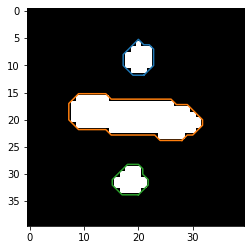

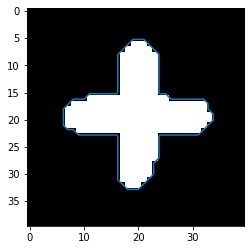

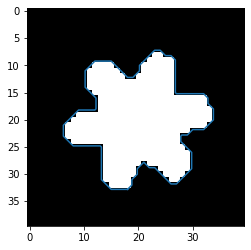

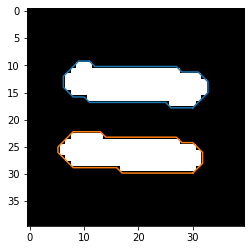

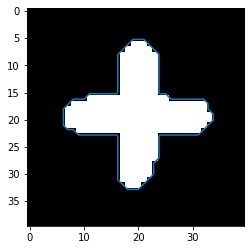

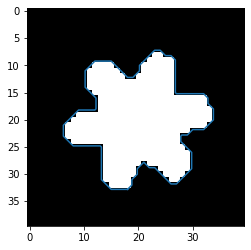

In [9]:
# operators cropped from the video
data_path = os.path.join('..\data')
crop1= skimage.io.imread(os.path.join(data_path, 'crop1.png'))
crop2 = skimage.io.imread(os.path.join(data_path, 'crop2.png'))
crop3 = skimage.io.imread(os.path.join(data_path, 'crop3.png'))
crop4 = skimage.io.imread(os.path.join(data_path, 'crop4.png'))

from skimage.color import rgb2gray
# convert in rgb in bw images 
crop1 = rgb2gray(crop1)
crop2 = rgb2gray(crop2)
crop3 = rgb2gray(crop3)
crop4 = rgb2gray(crop4)


# extend dim and concatenate
crop1 = np.expand_dims(crop1,axis = 0)
crop2 = np.expand_dims(crop2,axis = 0)
crop3 = np.expand_dims(crop3,axis = 0)
crop4 = np.expand_dims(crop4,axis = 0)
crop_operators = np.concatenate([crop1,crop2,crop3,crop4], axis = 0)
crop_operators = np.expand_dims(crop_operators,axis = 0)

#print(crop_operators.shape)
from skimage.transform import resize

crop_operators_resized = np.empty((1,4,40,40))

for N in range(crop_operators.shape[0]) :
    for idx,op in enumerate(crop_operators[N]) : 
        op = resize(op,(40,40), anti_aliasing = True)
        thresh = threshold_otsu(op)
        op = op<thresh
        plt.figure()
        plt.imshow(op,cmap='gray')
        contour1 = find_contours(op,0.2)
        plt.plot(contour1[0][:,1],contour1[0][:,0])
        if (len(contour1 )== 2) :
            plt.plot(contour1[1][:,1],contour1[1][:,0])
        if (len(contour1 )== 3) :
            plt.plot(contour1[1][:,1],contour1[1][:,0])
            plt.plot(contour1[2][:,1],contour1[2][:,0])
        crop_operators_resized[N,idx] = op.astype(float)
#print(crop_operators_resized.shape)

plt.figure()
plt.imshow(crop_operators_resized[0,1],cmap='gray')
contour1 = find_contours(crop_operators_resized[0,1],0.2)
#print(contour1[0][:,1])
plt.plot(contour1[0][:,1],contour1[0][:,0])
plt.figure()
plt.imshow(crop_operators_resized[0,2],cmap='gray')
contour = find_contours(crop_operators_resized[0,2],0.2)
#print(contour[0][:,1])
plt.plot(contour[0][:,1],contour[0][:,0])

# get features

features_crop = get_features(crop_operators_resized,6)
print(features_crop)

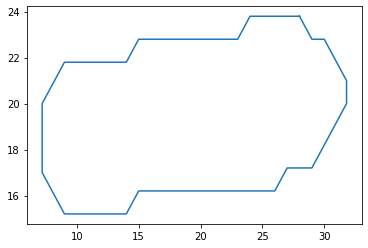

In [10]:
contour_minus = find_contours(crop_operators_resized[0,0],0.2)
plt.plot(contour_minus[1][:, 1],contour_minus[1][:, 0])
contour_complex = np.empty(contour_minus[1].shape[0], dtype=complex)
contour_complex.real = contour_minus[1][:, 0]
contour_complex.imag = contour_minus[1][:, 1]
fourier_result = np.fft.fft(contour_complex)
DFT = np.fft.fft(contour_complex)
coeff = DFT[:6]
A1 = np.sqrt(coeff[1].real**2+coeff[1].imag**2)
A2 = np.sqrt(coeff[2].real**2+coeff[2].imag**2)
A3 = np.sqrt(coeff[3].real**2+coeff[3].imag**2)
A4 = np.sqrt(coeff[4].real**2+coeff[4].imag**2)
A5 = np.sqrt(coeff[5].real**2+coeff[5].imag**2)
# compute ratios of Fourier descriptors -> scale invariant
coord_x = (A1/A5)
coord_y = (A2/A5)
coord_z = (A3/A4)
#coord_w = (A4/A5)
#coord_v = (A5/A0)
# concatenate the features 
features_minus = np.array([coord_x,coord_y,coord_z])

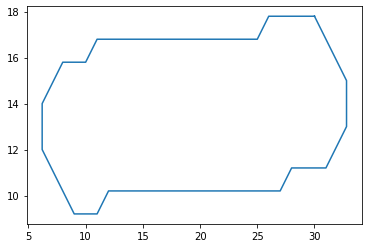

In [11]:
contour_minus2 = find_contours(crop_operators_resized[0,3],0.2)
plt.plot(contour_minus2[0][:, 1],contour_minus2[0][:, 0])
contour_complex = np.empty(contour_minus2[0].shape[0], dtype=complex)
contour_complex.real = contour_minus2[0][:, 0]
contour_complex.imag = contour_minus2[0][:, 1]
fourier_result = np.fft.fft(contour_complex)
DFT = np.fft.fft(contour_complex)
coeff = DFT[:6]
A1 = np.sqrt(coeff[1].real**2+coeff[1].imag**2)
A2 = np.sqrt(coeff[2].real**2+coeff[2].imag**2)
A3 = np.sqrt(coeff[3].real**2+coeff[3].imag**2)
A4 = np.sqrt(coeff[4].real**2+coeff[4].imag**2)
A5 = np.sqrt(coeff[5].real**2+coeff[5].imag**2)
# compute ratios of Fourier descriptors -> scale invariant
coord_x = (A1/A5)
coord_y = (A2/A5)
coord_z = (A3/A4)
#coord_w = (A4/A5)
#coord_v = (A5/A0)
# concatenate the features 
features_minus2 = np.array([coord_x,coord_y,coord_z])

In [12]:
def plot_two_Fourier_descriptor(features , target, coeff1,coeff2 ) :
    
    for idx,t in enumerate(target) : 
        if (t == 0) :
            add = plt.scatter(features[idx,coeff1],features[idx,coeff2],c='red')
        #if (t == 1) :
            #equal = plt.scatter(features[idx,coeff1],features[idx,coeff2],c='blue')
        if (t == 2) :
            minus = plt.scatter(features[idx,coeff1],features[idx,coeff2],c='orange')
        #if (t == 3) :
            #div = plt.scatter(features[idx,coeff1],features[idx,coeff2],c='green')
        if (t == 4) :
            mul = plt.scatter(features[idx,coeff1],features[idx,coeff2],c='purple')
    
    plt.legend((add,minus,mul),('add','minus','mul'))

Text(0.996475263380316, 5.6009415133920095, 'minus')

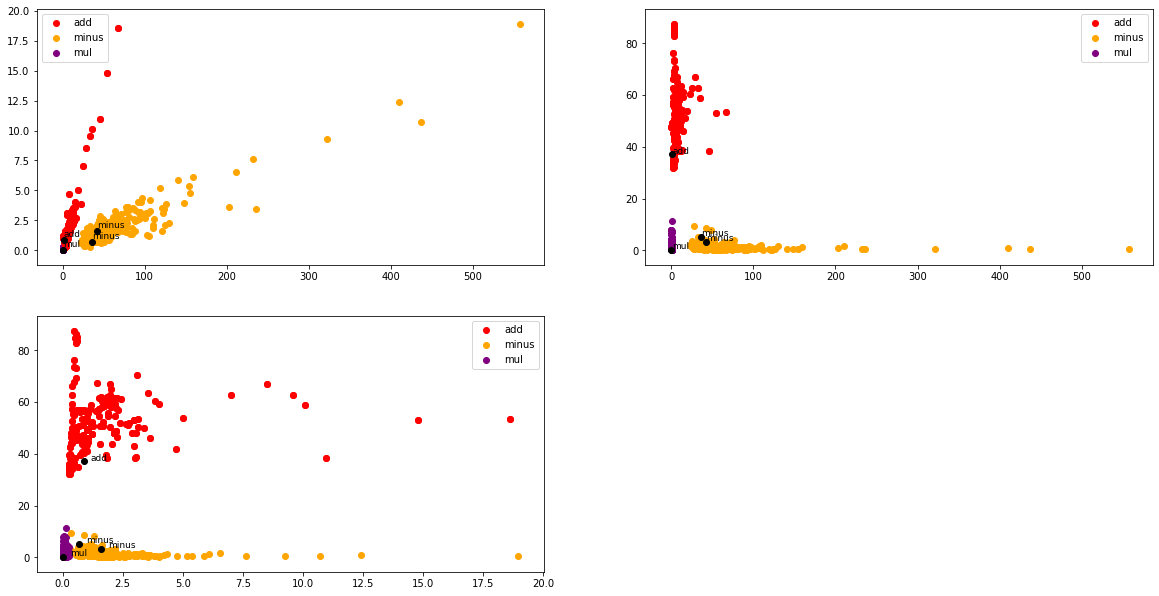

In [13]:
plt.figure(figsize=(20,16))
plt.subplot(321)
plot_two_Fourier_descriptor(features , targets,0,1 )
plt.scatter(features_minus[0],features_minus[1],c ='black')
plt.text(features_minus[0]+0.3, features_minus[1]+0.3, 'minus', fontsize=9)
plt.scatter(features_crop[1,0],features_crop[1,1],c ='black')
plt.text(features_crop[1,0]+0.3, features_crop[1,1]+0.3, 'add', fontsize=9)
plt.scatter(features_crop[2,0],features_crop[2,1],c ='black')
plt.text(features_crop[2,0]+0.3, features_crop[2,1]+0.3, 'mul', fontsize=9)
plt.scatter(features_minus2[0],features_minus2[1],c ='black')
plt.text(features_minus2[0]+0.3, features_minus2[1]+0.3, 'minus', fontsize=9)
plt.subplot(322)
plot_two_Fourier_descriptor(features , targets,0,2 )
plt.scatter(features_minus[0],features_minus[2],c ='black')
plt.text(features_minus[0]+0.3, features_minus[2]+0.3, 'minus', fontsize=9)
plt.scatter(features_crop[1,0],features_crop[1,2],c ='black')
plt.text(features_crop[1,0]+0.3, features_crop[1,2]+0.3, 'add', fontsize=9)
plt.scatter(features_crop[2,0],features_crop[2,2],c ='black')
plt.text(features_crop[2,0]+0.3, features_crop[2,2]+0.3, 'mul', fontsize=9)
plt.scatter(features_minus2[0],features_minus2[2],c ='black')
plt.text(features_minus2[0]+0.3, features_minus2[2]+0.3, 'minus', fontsize=9)
plt.subplot(323)
plot_two_Fourier_descriptor(features , targets,1,2 )
plt.scatter(features_minus[1],features_minus[2],c ='black')
plt.text(features_minus[1]+0.3, features_minus[2]+0.3, 'minus', fontsize=9)
plt.scatter(features_crop[1,1],features_crop[1,2],c ='black')
plt.text(features_crop[1,1]+0.3, features_crop[1,2]+0.3, 'add', fontsize=9)
plt.scatter(features_crop[2,1],features_crop[2,2],c ='black')
plt.text(features_crop[2,1]+0.3, features_crop[2,2]+0.3, 'mul', fontsize=9)
plt.scatter(features_minus2[1],features_minus2[2],c ='black')
plt.text(features_minus2[1]+0.3, features_minus2[2]+0.3, 'minus', fontsize=9)

In [14]:
features_knn,targets_knn = get_features(operators_knn,6,True)
features_knn = features_knn[:,:3]
print(features_knn.shape)
print(targets_knn.shape)

(1080, 3)
(1080,)


### Classifier

In [15]:
#split dataset into train and test data
X_train, X_test, y_train, y_test = train_test_split(features_knn,targets_knn, test_size=0.2, random_state=1)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

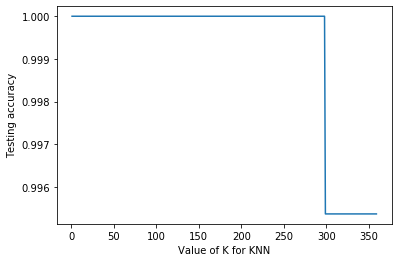

In [16]:
k_range = range(1,360)
scores = {}
scores_list = []
for k in k_range :
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train,y_train)
    y_pred = knn.predict(X_test)
    scores[k] = metrics.accuracy_score(y_test,y_pred)
    scores_list.append(metrics.accuracy_score(y_test,y_pred))
    
plt.plot(k_range,scores_list)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing accuracy')
print(scores_list)

In [17]:
# Tuned knn
knn_tuned = KNeighborsClassifier(n_neighbors = 5)
knn_tuned.fit(features_knn, targets_knn)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [18]:
filename = 'model_operators.sav'
pickle.dump(knn_tuned, open(filename, 'wb'))